# LineageOT demo

This notebook runs a simulation of one of three flow fields, computes optimal transport couplings with and without lineage information, and compares their accuracy at predicting cells' ancestors and descendants.

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import ot

import lineageot.simulation as sim
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf

In [2]:
# Choosing one of the three flow fields from the paper
# Uncomment the one you would like to simulate

#flow_type = 'bifurcation'
flow_type = 'convergent'
#flow_type = 'partial_convergent'
#flow_type = 'mismatched_clusters'

In [3]:

# Setting simulation parameters
np.random.seed(257) 

if flow_type == 'bifurcation':
    timescale = 1
else:
    timescale = 100

x0_speed = 1/timescale


sim_params = sim.SimulationParameters(division_time_std = 0.01*timescale,
                                      flow_type = flow_type,
                                      x0_speed = x0_speed,
                                      mutation_rate = 1/timescale,
                                      mean_division_time = 1.1*timescale,
                                      timestep = 0.001*timescale
                                     )

# These parameters can be adjusted freely.
# As is, they replicate the plots in the paper for the fully convergent simulation.
mean_x0_early = 2
time_early = 7.4*timescale # Time when early cells are sampled
time_late = time_early + 4*timescale # Time when late cells are sampled
x0_initial = mean_x0_early -time_early*x0_speed
initial_cell = sim.Cell(np.array([x0_initial, 0, 0]), np.zeros(sim_params.barcode_length))
sample_times = {'early' : time_early, 'late' : time_late}



# Choosing which of the three dimensions to show in later plots
if flow_type == 'mismatched_clusters':
    dimensions_to_plot = [1,2]
else:
    dimensions_to_plot = [0,1]


## Running the simulation
%time sample = sim.sample_descendants(initial_cell.deepcopy(), time_late, sim_params)


CPU times: user 14 s, sys: 63 ms, total: 14 s
Wall time: 14.1 s


In [4]:
# Extracting trees and barcode matrices
true_trees = {'late':sim_inf.list_tree_to_digraph(sample)}
true_trees['late'].nodes['root']['cell'] = initial_cell

true_trees['early'] = sim_inf.truncate_tree(true_trees['late'], sample_times['early'], sim_params)

# Computing the ground-truth coupling
couplings = {'true': sim_inf.get_true_coupling(true_trees['early'], true_trees['late'])}

In [5]:
data_arrays = {'late' : sim_inf.extract_data_arrays(true_trees['late'])}
rna_arrays = {'late': data_arrays['late'][0]}
barcode_arrays = {'late': data_arrays['late'][1]}

rna_arrays['early'] = sim_inf.extract_data_arrays(true_trees['early'])[0]
num_cells = {'early': rna_arrays['early'].shape[0], 'late': rna_arrays['late'].shape[0]}

print("Times    : ", sample_times)
print("Number of cells: ", num_cells)

Times    :  {'early': 740.0, 'late': 1140.0}
Number of cells:  {'early': 64, 'late': 1024}


In [6]:
# Creating a copy of the true tree for use in LineageOT
true_trees['late, annotated'] = copy.deepcopy(true_trees['late'])
sim_inf.add_node_times_from_division_times(true_trees['late, annotated'])

sim_inf.add_nodes_at_time(true_trees['late, annotated'], sample_times['early']);

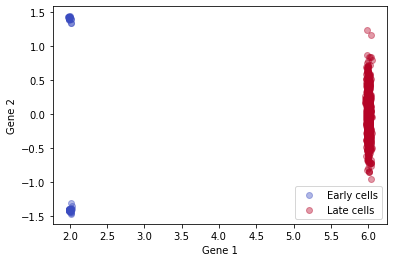

In [7]:
# Scatter plot of cell states

cmap = "coolwarm"
colors = [plt.get_cmap(cmap)(0), plt.get_cmap(cmap)(256)]
for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)


plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.legend();


In [8]:
# Infer ancestor locations for the late cells based on the true lineage tree

observed_nodes = [n for n in sim_inf.get_leaves(true_trees['late, annotated'], include_root=False)]
sim_inf.add_conditional_means_and_variances(true_trees['late, annotated'], observed_nodes)

ancestor_info = {'true tree':sim_inf.get_ancestor_data(true_trees['late, annotated'], sample_times['early'])}

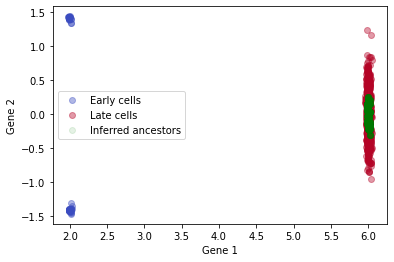

In [9]:
# Scatter plot of cell states, with inferred ancestor locations for the late cells

for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

plt.scatter(ancestor_info['true tree'][0][:,dimensions_to_plot[0]],
            ancestor_info['true tree'][0][:,dimensions_to_plot[1]],
            alpha = 0.1,
            label = 'Inferred ancestors',
            color = 'green')
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.legend();





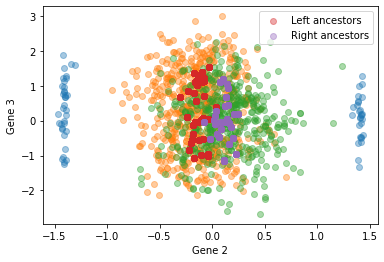

In [10]:
# To better visualize cases where there were two clusters at the early time point,
# we can color the late cells (and their inferred ancestors) by their cluster of origin
is_from_left = sim_inf.extract_ancestor_data_arrays(true_trees['late'], sample_times['early'], sim_params)[0][:,1] < 0
for a,label in zip([rna_arrays['early'], rna_arrays['late'][is_from_left,:], rna_arrays['late'][~is_from_left,:]], ['Early cells', 'Late cells from left', 'Late cells from right']):
    plt.scatter(a[:, 1], a[:, 2], alpha = 0.4)

plt.xlabel('Gene 2')
plt.ylabel('Gene 3')


for a, label in zip([ancestor_info['true tree'][0][is_from_left, :], ancestor_info['true tree'][0][~is_from_left, :]], ['Left ancestors', 'Right ancestors']):
    plt.scatter(a[:,1], a[:,2], alpha = 0.4, label = label)
plt.legend()

### Fitting a lineage tree to barcodes

In [11]:
%%time
# True distances
true_distances = {key:sim_inf.compute_tree_distances(true_trees[key]) for key in true_trees}


CPU times: user 2min 14s, sys: 805 ms, total: 2min 15s
Wall time: 2min 16s


In [12]:
# Estimate mutation rate from fraction of unmutated barcodes

rate_estimate = sim_inf.rate_estimator(barcode_arrays['late'], sample_times['late'])

print("Fraction unmutated barcodes: ", {key:np.sum(barcode_arrays[key] == 0)/barcode_arrays[key].size
                                        for key in barcode_arrays})
print()

print("Rate estimate: ", rate_estimate)
print("True rate: ", sim_params.mutation_rate/sim_params.barcode_length)
print("Rate accuracy: ", rate_estimate*sim_params.barcode_length/sim_params.mutation_rate)

Fraction unmutated barcodes:  {'late': 0.47311197916666664}

Rate estimate:  0.0006565115579693221
True rate:  0.0006666666666666666
Rate accuracy:  0.9847673369539832


In [13]:
# Compute Hamming distance matrices for neighbor joining

hamming_distances_with_roots = {'late':sim_inf.barcode_distances(np.concatenate([barcode_arrays['late'],
                                                                                         np.zeros([1,sim_params.barcode_length])]))}



In [14]:
# Compute neighbor-joining tree

fitted_tree = sim_inf.neighbor_join(hamming_distances_with_roots['late'])

In [15]:
# Annotate fitted tree with internal node times

sim_inf.add_leaf_barcodes(fitted_tree, barcode_arrays['late'])
sim_inf.add_leaf_x(fitted_tree, rna_arrays['late'])
sim_inf.add_leaf_times(fitted_tree, sample_times['late'])
sim_inf.annotate_tree(fitted_tree,
                  rate_estimate*np.ones(sim_params.barcode_length),
                  time_inference_method = 'least_squares');

     pcost       dcost       gap    pres   dres
 0: -6.3033e+08 -6.5015e+08  1e+08  2e-01  2e-01
 1: -6.2945e+08 -6.6103e+08  4e+07  4e-02  6e-02
 2: -6.2910e+08 -6.4660e+08  2e+07  1e-02  2e-02
 3: -6.3080e+08 -6.3880e+08  8e+06  4e-03  6e-03
 4: -6.3112e+08 -6.3682e+08  6e+06  3e-04  5e-04
 5: -6.3180e+08 -6.3502e+08  3e+06  1e-04  2e-04
 6: -6.3224e+08 -6.3378e+08  2e+06  3e-05  4e-05
 7: -6.3254e+08 -6.3282e+08  3e+05  1e-16  3e-16
 8: -6.3260e+08 -6.3262e+08  2e+04  1e-16  3e-16
 9: -6.3261e+08 -6.3261e+08  7e+02  1e-16  7e-16
10: -6.3261e+08 -6.3261e+08  3e+01  1e-16  1e-15
Optimal solution found.


In [16]:
# Add inferred ancestor nodes and states

sim_inf.add_node_times_from_division_times(fitted_tree)

sim_inf.add_nodes_at_time(fitted_tree, sample_times['early'])

observed_nodes = [n for n in sim_inf.get_leaves(fitted_tree, include_root = False)]
sim_inf.add_conditional_means_and_variances(fitted_tree, observed_nodes)

ancestor_info['fitted tree'] = sim_inf.get_ancestor_data(fitted_tree, sample_times['early'])

### Computing cost matrices

In [17]:
# Compute cost matrices for each method
coupling_costs = {}
coupling_costs['lineageOT, true tree'] = ot.utils.dist(rna_arrays['early'], ancestor_info['true tree'][0])@np.diag(ancestor_info['true tree'][1]**(-1))
coupling_costs['OT'] = ot.utils.dist(rna_arrays['early'], rna_arrays['late'])
coupling_costs['lineageOT, fitted tree'] = ot.utils.dist(rna_arrays['early'], ancestor_info['fitted tree'][0])@np.diag(ancestor_info['fitted tree'][1]**(-1))



early_time_rna_cost = ot.utils.dist(rna_arrays['early'], sim_inf.extract_ancestor_data_arrays(true_trees['late'], sample_times['early'], sim_params)[0])
late_time_rna_cost = ot.utils.dist(rna_arrays['late'], rna_arrays['late'])



In [18]:
%%time
# Fit couplings with a range of entropy parameters

epsilons = np.logspace(-2, 3, 15)

couplings['OT'] = ot.emd([],[],coupling_costs['OT'])
couplings['lineageOT'] = ot.emd([], [], coupling_costs['lineageOT, true tree'])
couplings['lineageOT, fitted'] = ot.emd([], [], coupling_costs['lineageOT, fitted tree'])
for e in epsilons:
    if e >=0.1:
        f = ot.sinkhorn
    else:
        # Epsilon scaling is more robust at smaller epsilon, but slower than simple sinkhorn
        f = ot.bregman.sinkhorn_epsilon_scaling
    print("Working on couplings for epsilon = " + str(e) + " .")
    couplings['entropic rna ' + str(e)] = f([],[],coupling_costs['OT'], e)
    couplings['lineage entropic rna ' + str(e)] = f([], [], coupling_costs['lineageOT, true tree'], e*np.mean(ancestor_info['true tree'][1]**(-1)))
    couplings['fitted lineage rna ' + str(e)] = f([], [], coupling_costs['lineageOT, fitted tree'], e*np.mean(ancestor_info['fitted tree'][1]**(-1)))

Working on couplings for epsilon = 0.01 .
Working on couplings for epsilon = 0.022758459260747887 .
Working on couplings for epsilon = 0.05179474679231213 .
Working on couplings for epsilon = 0.11787686347935872 .
Working on couplings for epsilon = 0.2682695795279726 .
Working on couplings for epsilon = 0.6105402296585329 .
Working on couplings for epsilon = 1.3894954943731375 .
Working on couplings for epsilon = 3.1622776601683795 .
Working on couplings for epsilon = 7.196856730011521 .
Working on couplings for epsilon = 16.378937069540648 .
Working on couplings for epsilon = 37.27593720314942 .
Working on couplings for epsilon = 84.83428982440725 .
Working on couplings for epsilon = 193.06977288832496 .
Working on couplings for epsilon = 439.3970560760795 .
Working on couplings for epsilon = 1000.0 .
CPU times: user 9.16 s, sys: 54.4 ms, total: 9.21 s
Wall time: 2.31 s


### Evaluation of fitted couplings

In [19]:
%%time
couplings['independent'] = np.ones(couplings['OT'].shape)/couplings['OT'].size
ind_ancestor_error = sim_inf.OT_cost(couplings['independent'], early_time_rna_cost)
ind_descendant_error = sim_inf.OT_cost(sim_eval.expand_coupling(couplings['independent'],
                                                                couplings['true'],
                                                                late_time_rna_cost),
                                       late_time_rna_cost)

print(ind_ancestor_error)
print(ind_descendant_error)


5.088783359469203
1.22498609269999
CPU times: user 1.24 s, sys: 36.4 ms, total: 1.28 s
Wall time: 713 ms


CPU times: user 143 ms, sys: 3.59 ms, total: 147 ms
Wall time: 37.3 ms


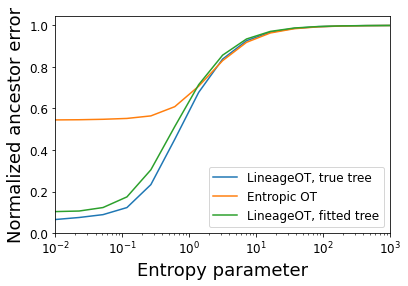

In [20]:
%%time
# Plot accuracy of ancestor prediction
ancestor_errors = sim_eval.plot_metrics(couplings, lambda x:sim_inf.OT_cost(x, early_time_rna_cost), 'Normalized ancestor error', epsilons, scale = ind_ancestor_error, points=False)


CPU times: user 54.2 s, sys: 1.6 s, total: 55.8 s
Wall time: 32 s


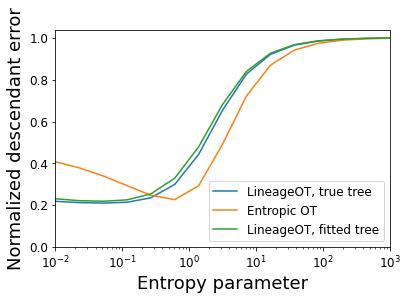

In [21]:
%%time
# Plot accuracy of descendant prediction
descendant_errors = sim_eval.plot_metrics(couplings,
                      lambda x:sim_inf.OT_cost(sim_eval.expand_coupling(x, couplings['true'], late_time_rna_cost), late_time_rna_cost),
                      'Normalized descendant error',
                      epsilons, scale = ind_descendant_error)


### Evaluating the accuracy of the fitted tree

In [ ]:
%time fitted_tree_distances = sim_inf.compute_tree_distances(fitted_tree)

In [ ]:
# Plotting the accuracy of tree distances estimated by Hamming distance between barcodes

hamming_distances = (hamming_distances_with_roots['late'][np.triu_indices(num_cells['late'])])/rate_estimate
true_tree_distances = true_distances['late'][np.triu_indices(num_cells['late'])]
plt.scatter(hamming_distances,
            true_tree_distances,
            s = 2,
            alpha = 0.3)
plt.ylabel('True tree distances')
plt.xlabel('Adjusted Hamming distances')
print('Correlation: ', np.corrcoef(hamming_distances, true_tree_distances)[0,1])
print('Robinson-Foulds tree accuracy: ', sim_inf.tree_accuracy(fitted_tree, true_trees['late']))

In [ ]:
# Plotting the accuracy of tree distances,
# estimated after imposing the constraint that all leaves are the same distance from the root

plt.scatter(fitted_tree_distances[np.triu_indices(num_cells['late'])],
            true_distances['late'][np.triu_indices(num_cells['late'])],
            s = 2,
            alpha = 0.3)
plt.ylabel('True tree distances')
plt.xlabel('Fitted distances with correction')
print('Correlation: ', np.corrcoef(fitted_tree_distances[np.triu_indices(num_cells['late'])],
                                   true_distances['late'][np.triu_indices(num_cells['late'])])[0,1]
     )
print('Robinson-Foulds tree accuracy: ', sim_inf.tree_accuracy(fitted_tree, true_trees['late']))


### Coupling sketches

Here we plot the ground-truth, zero-entropy optimal transport, and zero-entropy LineageOT couplings.


In [ ]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['true'],
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)

plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('True coupling')


for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

In [ ]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['lineageOT'],
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('LineageOT coupling')

for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)





In [ ]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['OT'],
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('OT coupling')


for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)




